In [1]:
import cv2 #opencv-python
import os
from collections import defaultdict
import numpy as np
from rtree import index
import matplotlib.pyplot as plt

TODO: probar lo mismo solo que sin extraer features con sift, usar extracción "normal", para que esté igual que los otros knn

In [16]:
dataset_path = "../data/tiny_dataset"

sift = cv2.SIFT_create() #Instanciamos un objeto SIFT de opencv

descriptor_list = []  
keypoint_list = []  

for filename in os.listdir(dataset_path):
    image_path = os.path.join(dataset_path,filename)
    image = cv2.imread(image_path, 0) #leer imagen en grayscale

    keypoints, descriptors = sift.detectAndCompute(image, None) #calcular descriptores y keypoint  

    if descriptors is None: # A veces hay problemas con imagenes de productos blancos con el fondo blanco
        print(f"No descriptors found for image: {filename}")
        continue

    # descriptor promedio ( para tener un shape: 1 x 128)
    aggregated_descriptor = np.mean(descriptors, axis=0)

    descriptor_list.append(aggregated_descriptor)
    keypoint_list.append(keypoints)

print(f"Procesadas {len(descriptor_list)} imágenes.")

descriptors = np.vstack(descriptor_list)
print(descriptors.shape)

Procesadas 165 imágenes.
(165, 128)


SIFT output: vectores 128-dimensionales. Shape de los descriptors (n_keypoints, 128), donde n_keypoints puede variar dependiendo de la imagen

In [17]:
# Métrica de distancia: Euclidiana
def euclidean_distance(P, Q):
    return np.sqrt(np.sum((P - Q) ** 2))

def create_rtree_index(descriptors):
    p = index.Property()
    p.dimension = 128  # Dimensión de los embeddings faciales
    idx = index.Index(properties=p)
    
    for i, descriptor in enumerate(descriptors):
        # Usamos cada dimensión como límite inferior y superior
        idx.insert(i, tuple(descriptor) + tuple(descriptor))
    return idx


# Búsqueda KNN usando R-Tree
def knn_rtree(query_vector, idx, descriptors, k=5):
    # Buscamos en el índice
    nearest_neighbors = list(idx.nearest(tuple(query_vector) + tuple(query_vector), k))
    # Retornamos los vecinos con sus distancias calculadas
    return [(i, euclidean_distance(query_vector, descriptors[i])) for i in nearest_neighbors]

def show_results(results, dataset_path):
    image_files = os.listdir(dataset_path)
    
    for index, distance in results:
        image_filename = image_files[index]
        image_path = os.path.join(dataset_path, image_filename)
        
        image = cv2.imread(image_path)
        if image is not None:

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.figure()
            plt.imshow(image)
            plt.title(f"Image {index} - Distance: {distance:.2f}")
            plt.axis('off')
        else:
            print(f"Error loading image at index {index}: {image_filename}")
    plt.show()




In [43]:
random = np.random.randint(len(descriptors))
query_vector = descriptors[random] #escojer imagen aleatoria entre los descriptores

k = 5
idx = create_rtree_index(descriptors)
rtree_result = knn_rtree(query_vector, idx, descriptors, k=k)

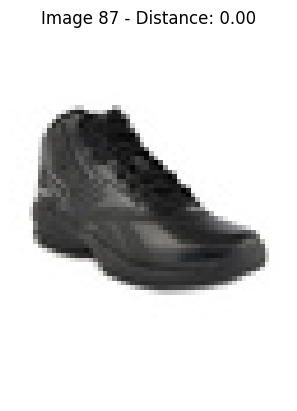

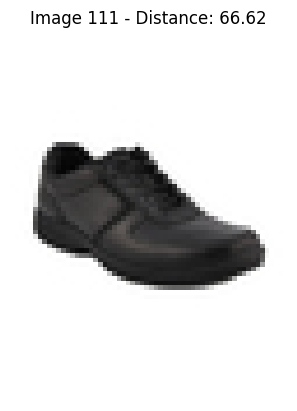

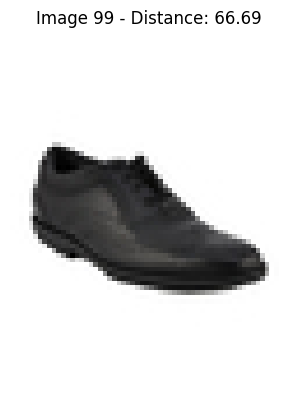

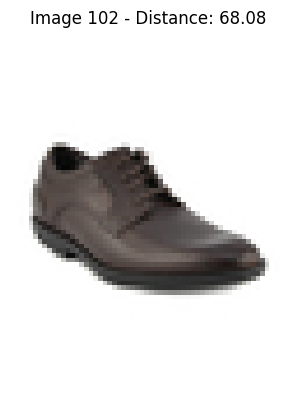

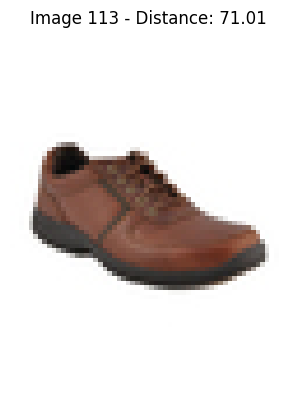

In [44]:
show_results(rtree_result, dataset_path)